<a href="https://colab.research.google.com/github/miamvmian/SciML/blob/main/%5BSOLVED%5D_Seminar_1_Basics_of_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

# Recap of the Machine Learning basics


## Supervised Machine Learning

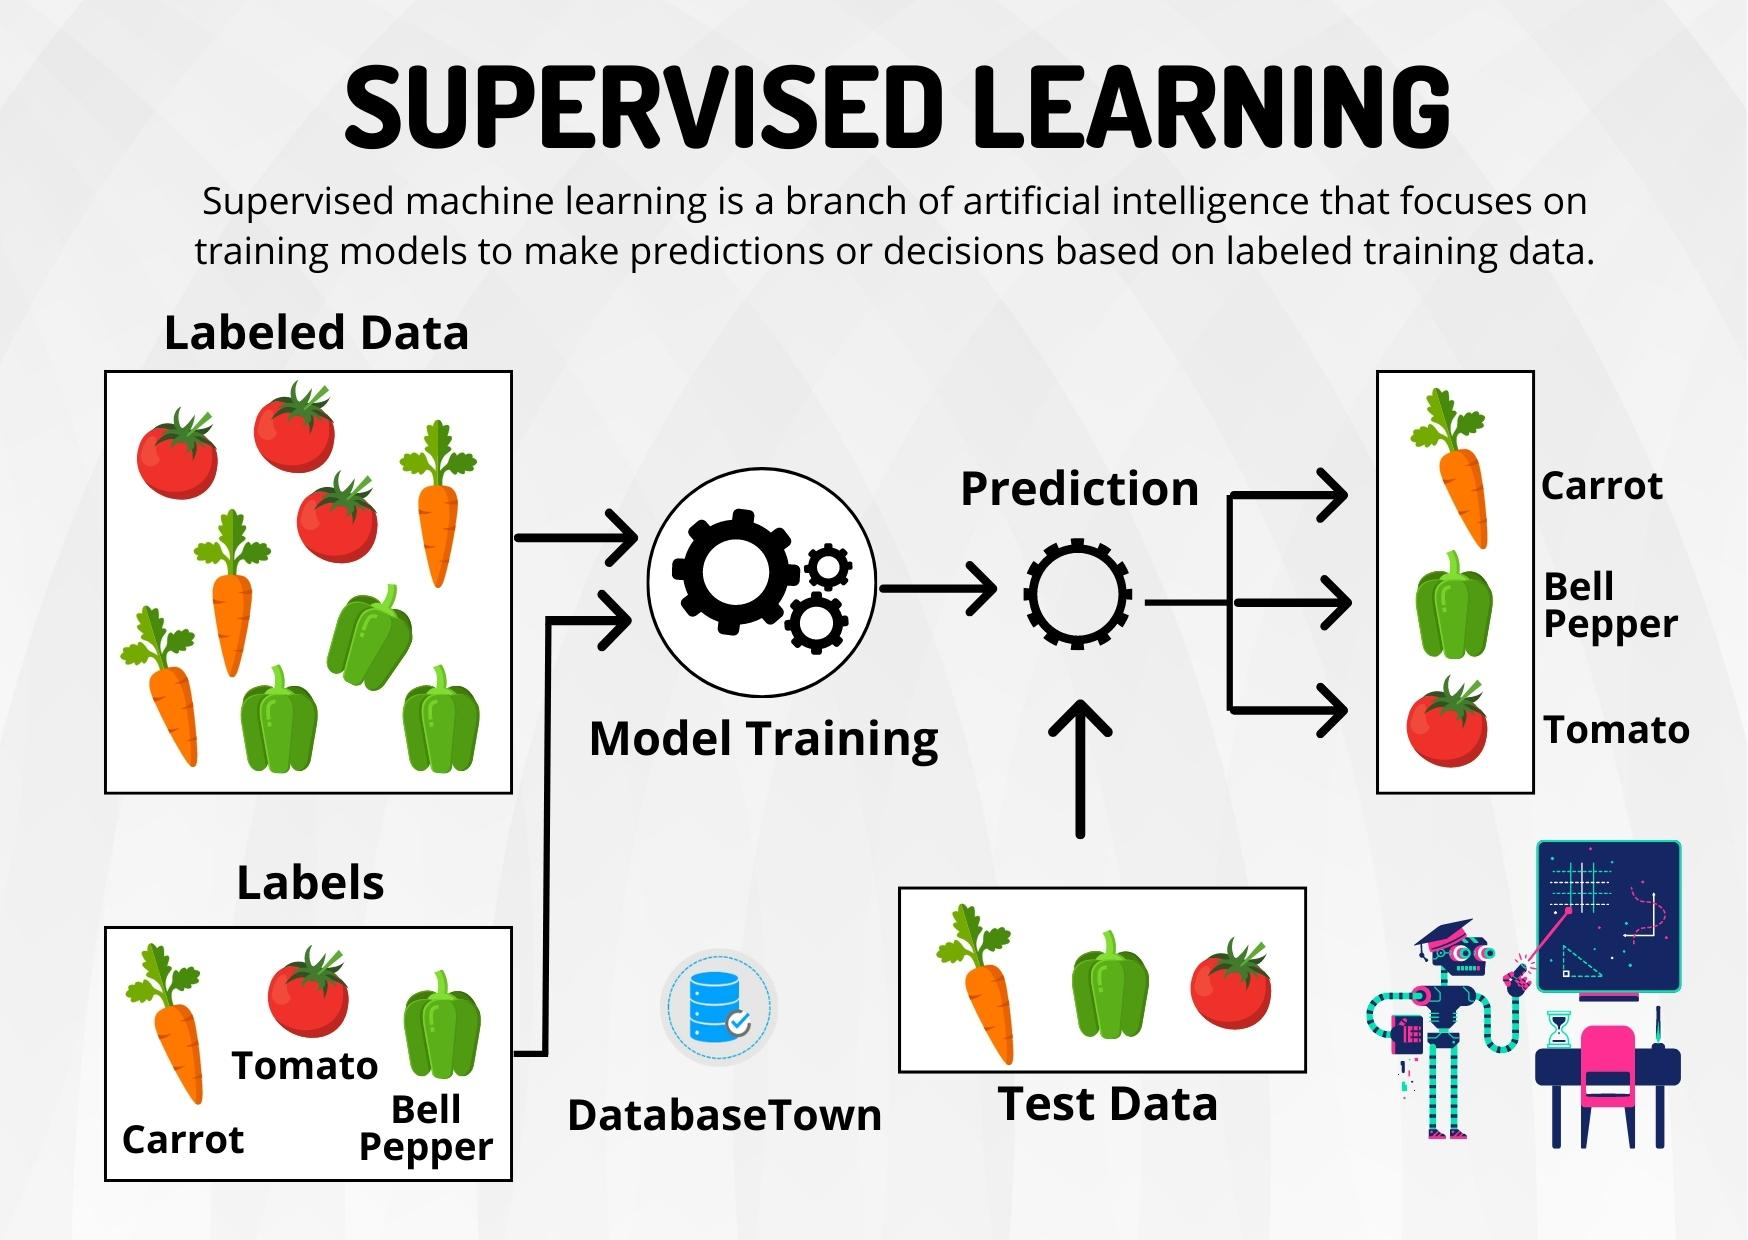

source : [link](https://databasetown.com/supervised-learning-algorithms/)


Basic definitions:

- Sample
- Features
- Labels
- Model
  - Parameters
  - Hyperparameters
- Prediction
- Loss function and score
- Likelihood


## Linear Regression


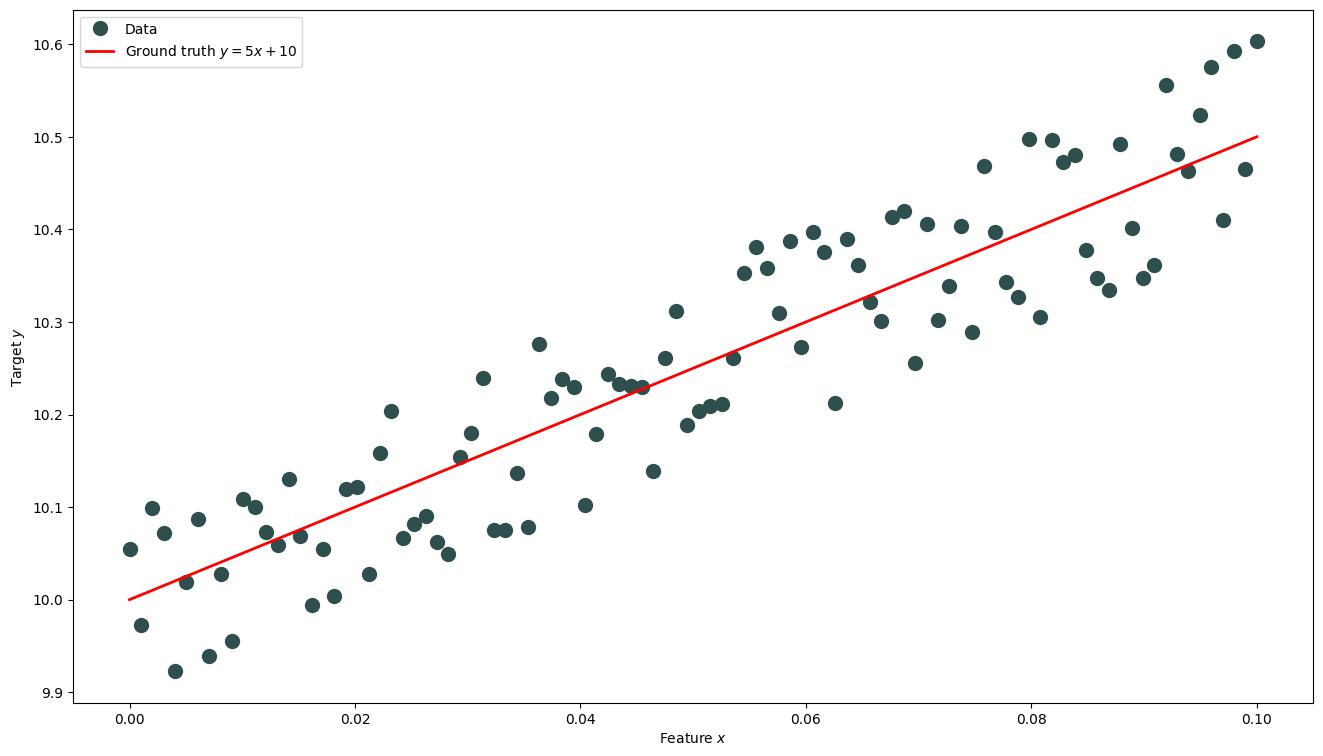

In [2]:
k_init = 5
b_init = 10

X = np.linspace(0, 0.1, 100)
y_real = k_init * X + b_init
noise = np.random.uniform(-0.1, 0.1, size=X.shape)
y_sampled = (noise + k_init) * X + b_init + noise

plt.figure(figsize=(16, 9))
plt.plot(X, y_sampled, 'o', color='darkslategray', label='Data', markersize=10)
plt.plot(X, y_real, 'r-', label=r'Ground truth $y = 5 x + 10$', linewidth=2)
plt.xlabel('Feature $x$')
plt.ylabel('Target $y$')
plt.legend()
# plt.savefig('init.png', dpi=300)
plt.show()

We need to build a model $\hat{f}$, which will take features $X_i$ of $i$th sample as input and outputs the prediction $\hat{y}_i=\hat{f}(X_i)$. We aim it to approximate the ground truth function, so $\hat{y}_i \approx y_i$, where $y_i$ is the ground truth label.

Which model will we use?

Let's propose:

Linear model with $\hat{y}_i=\hat{f}(X_i)=k \cdot X_i + b$


It can be rewritten as:

$$
\mathbf{\hat y} = \mathbf{X}\mathbf{w},
$$

where $\mathbf{X} = \begin{pmatrix} \mathbf{x}_1, 1\\ \ldots\\  \mathbf{x}_N, 1 \end{pmatrix} $, and $\mathbf{w} = (k, b)^T$

Then

$$
\mathbf{X}^{T} \mathbf{\hat y} = \mathbf{X}^{T} \mathbf{X} \mathbf{w}
$$

$$
(\mathbf{X}^{T} \mathbf{X})^{-1} \mathbf{X}^{T} \mathbf{\hat y} = (\mathbf{X}^{T} \mathbf{X})^{-1} (\mathbf{X}^{T} \mathbf{X}) \mathbf{w}
$$

$$
(\mathbf{X}^{T} \mathbf{X})^{-1} \mathbf{X}^{T} \mathbf{\hat y} = \mathbf{w}
$$

is the analytical formula for the solution


In [ ]:
def get_coef(X, y):
    X_new = np.hstack((
        X[np.newaxis].T,
        np.ones_like(X[np.newaxis].T)
    ))
    return np.linalg.inv(X_new.T @ X_new) @ X_new.T @ y

In [4]:
k, b = get_coef(X, y_sampled)

In [ ]:
k, b

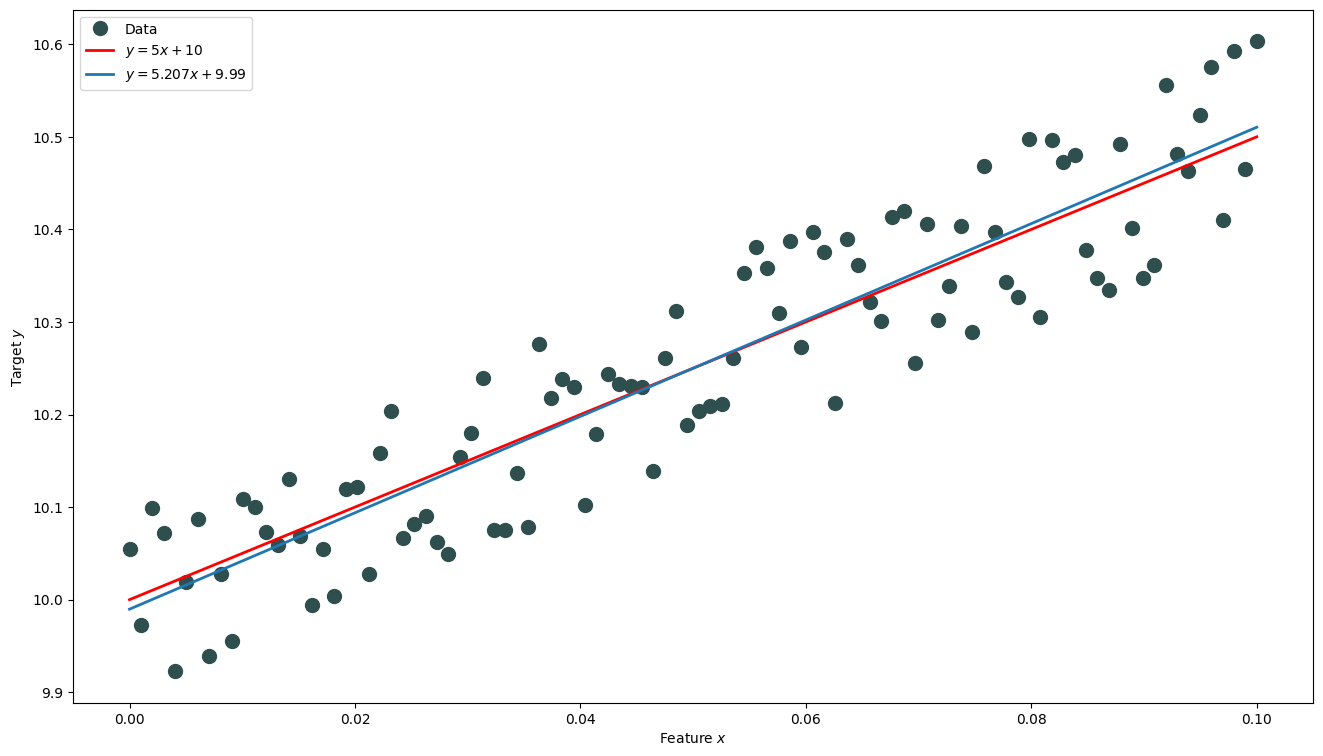

In [5]:
plt.figure(figsize=(16, 9))
plt.plot(X, y_sampled, 'o', color='darkslategray', label='Data', markersize=10)
plt.plot(X, y_real, 'r-', label=r'$y = 5 x + 10$', linewidth=2)
plt.plot(X, k * X + b, '-', label=r'$y =$'f'{np.round(k,3)}'r'$x +$'f'{np.round(b,3)}', linewidth=2)
plt.xlabel('Feature $x$')
plt.ylabel('Target $y$')
#plt.ylim(0, 1.1*np.max(y_real))
plt.legend()
#plt.savefig('mse.png', dpi=300)
plt.show()

## How to analyze: cross-plot, $R^2$ metric, MAPE

In [ ]:
def draw_crossplot(real, pred, ax, xmin=None, xmax=None,  **kwargs):
    if xmin is None:
        xmin = np.min([np.nanmin(real), np.nanmin(pred)])
    if xmax is None:
        xmax = np.max([np.nanmax(real), np.nanmax(pred)])
    df = (xmax - xmin)
    xmin = xmin - df / 10
    xmax = xmax + df / 10
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ax.plot((xmin, xmax), (xmin, xmax), 'k--', alpha=0.5, zorder=2)
    sc = ax.scatter(real, pred, **kwargs)
    ax.set_aspect('equal')

Text(0, 0.5, 'predicted data')

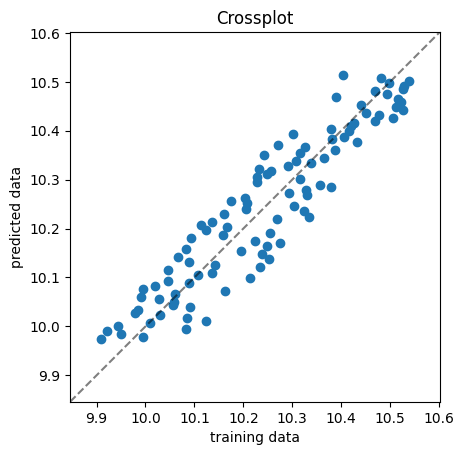

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.set_title('Crossplot')
draw_crossplot(y_sampled, k * X + b, ax)

ax.set_xlabel('training data')
ax.set_ylabel('predicted data')

R$^2$ score is:

$$
R^2 = 1 - \frac{ \frac{1}{N}\sum_i^N (y_i - \hat{y}_i)^2}{\frac{1}{N}\sum_i^N (y_i - \overline{y})^2}
$$

where $\overline{y} = \frac{1}{N} \sum_i^N (y_i)$

In [ ]:
def r2(real, pred):
    return 1.0 - np.mean(np.square(real - pred)) / np.var(real)

In [ ]:
print(r2(y_sampled, k * X + b))

NameError: name 'y_sampled' is not defined

MAPE is:

$$
\mathrm{MAPE} = 100\% \cdot \frac{1}{N}\cdot \frac{|y - \hat{y}|}{|y|}
$$

In [ ]:
def mape(real, pred):
    return 100 * np.mean(np.abs(real - pred) / np.abs(real))

In [ ]:
print(f'{mape(y_sampled, k * X + b):.1f}%')

0.5%


## Gradient optimization

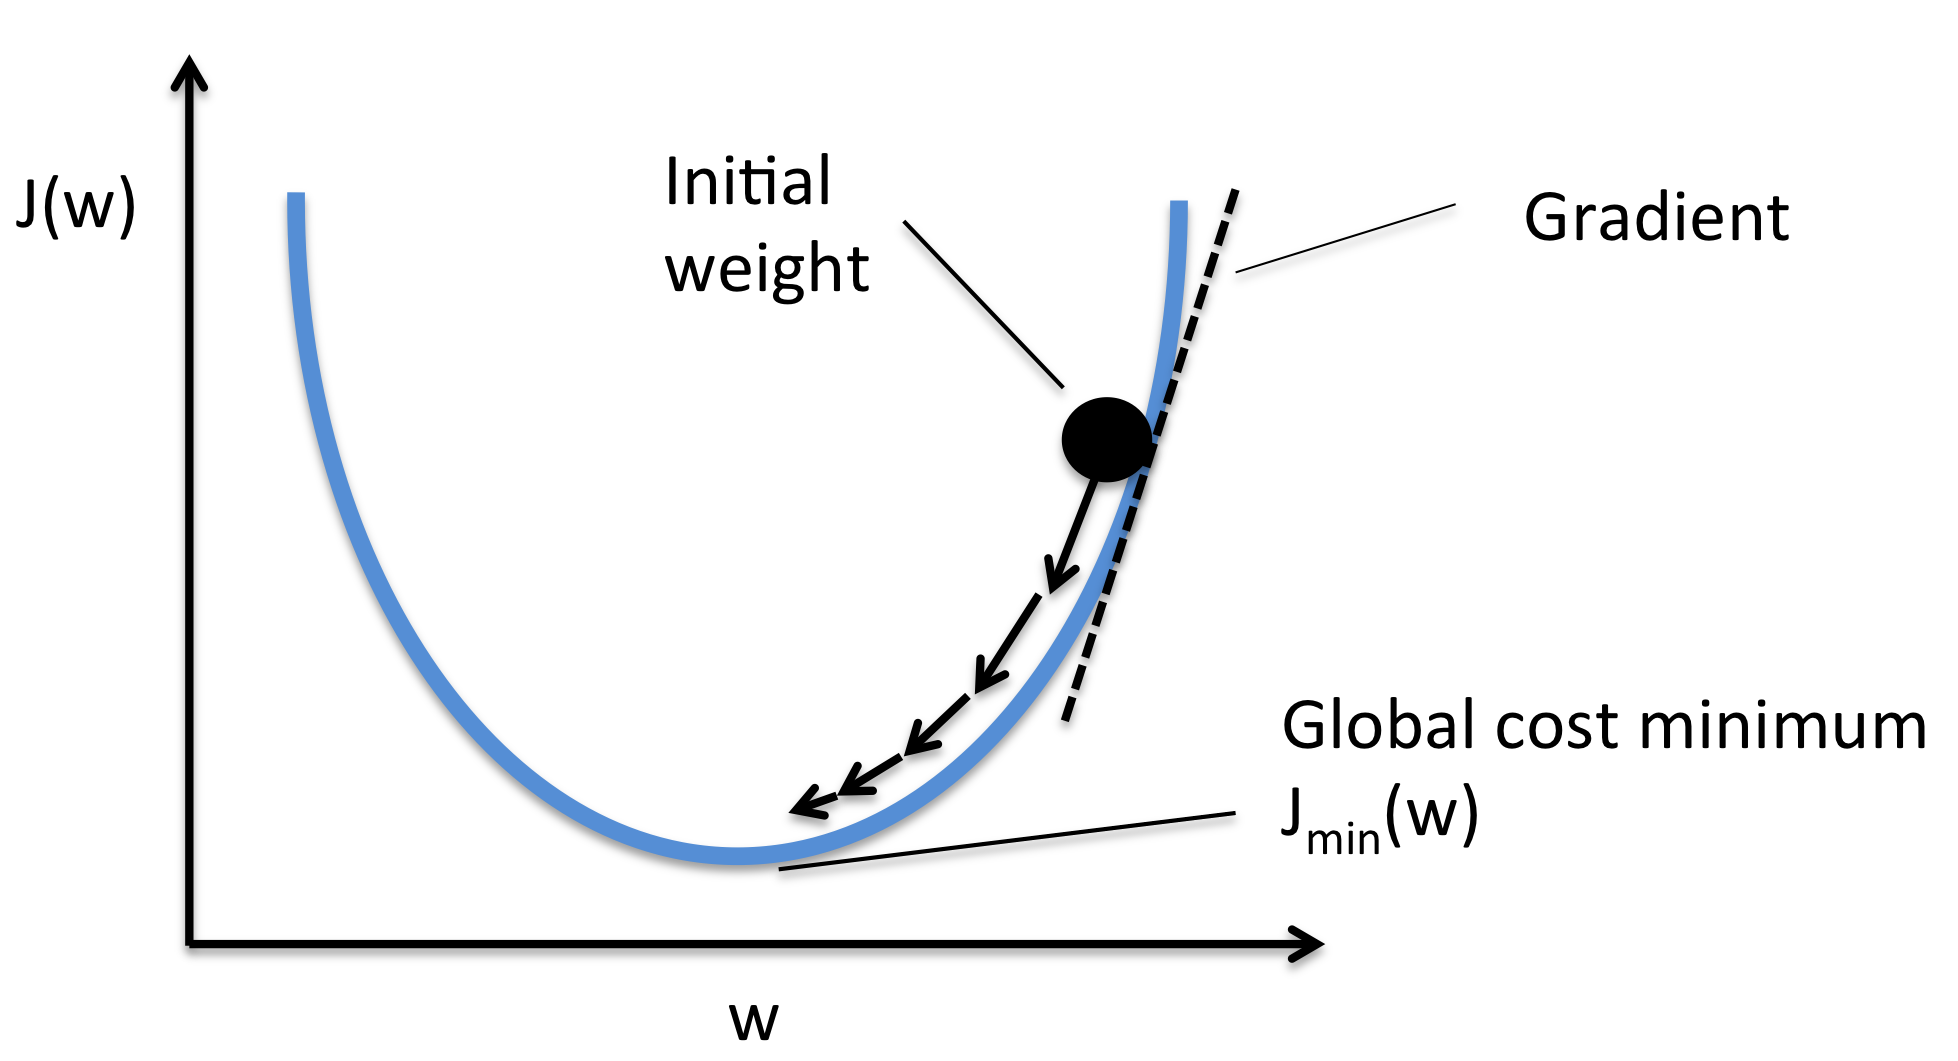

source: [link](https://sebastianraschka.com/faq/docs/gradient-optimization.html)


We can also solve by minimizing

$$
L = L^{\mathrm{MSE}}(\mathbf{y}, \mathbf{\hat y}) = L^{\mathrm{MSE}}(\mathbf{y}, \mathbf{X}\mathbf{w}) = \frac{1}{N} ||\mathbf{y}-\mathbf{X}\mathbf{w}||^2_2 = \frac{1}{N} \sum \left(\mathbf{y} - k \cdot x_i - b \right)^2
$$

$$
\frac{\partial L}{\partial k} = \frac{1}{N} \sum \frac{\partial}{\partial k} \left(\mathbf{y} - k \cdot x_i - b \right)^2
$$

$$
\frac{\partial L}{\partial k} = \frac{1}{N} \sum 2 \cdot \left(\mathbf{y} - k \cdot x_i - b \right) \cdot \frac{\partial}{\partial k} \left(\mathbf{y} - k \cdot x_i - b \right)
$$

$$
\frac{\partial L}{\partial k} = - \frac{2}{N} \sum x_i \cdot \left(\mathbf{y} - k \cdot x_i - b \right)
$$

Similarly,

$$
\frac{\partial L}{\partial b} = - \frac{2}{N} \sum \left(\mathbf{y} - k \cdot x_i - b \right)
$$

In [6]:
def grad(X, y, k, b):
    kb = np.array([k, b])
    X_new = np.hstack((
        X[np.newaxis].T,
        np.ones_like(X[np.newaxis].T)
    ))
    dL_dk = -2 * np.mean(X * (y_sampled - X_new @ kb))
    dL_db = -2 * np.mean(y_sampled - X_new @ kb)
    return dL_dk, dL_db

In [7]:
learning_rate = 0.1

k, b = 0, 0

for i in range(20001):
    dL_dk, dL_db = grad(X, y_sampled, k, b)
    k = k - learning_rate * dL_dk
    b = b - learning_rate * dL_db
    if not i % 1000:
        print(i, k, b)

0 0.1033858180349864 2.0500096720779184
1000 1.2448655880867527 10.18797321956973
2000 1.8630000627527301 10.157040263253117
3000 2.384694662196563 10.130933393443064
4000 2.824995707104187 10.108899655564835
5000 3.1966020268809796 10.090303569231283
6000 3.510231209675731 10.074608800198625
7000 3.774928710944234 10.061362691820218
8000 3.9983287356276604 10.050183209866233
9000 4.186874418111947 10.040747924181636
10000 4.34600365023195 10.032784709399731
11000 4.480305916831008 10.026063896508369
12000 4.593654662208207 10.020391648910156
13000 4.689319005066573 10.015604371934067
14000 4.770058023959713 10.011563994561786
15000 4.838200332546685 10.008153987287926
16000 4.895711239704336 10.005276001264258
17000 4.944249431478022 10.002847031796678
18000 4.98521480964883 10.00079702438666
19000 5.0197888666409405 9.999066854272458
20000 5.0489687612316585 9.99760662119747


Problem: it is too slow

## Adam optimizer

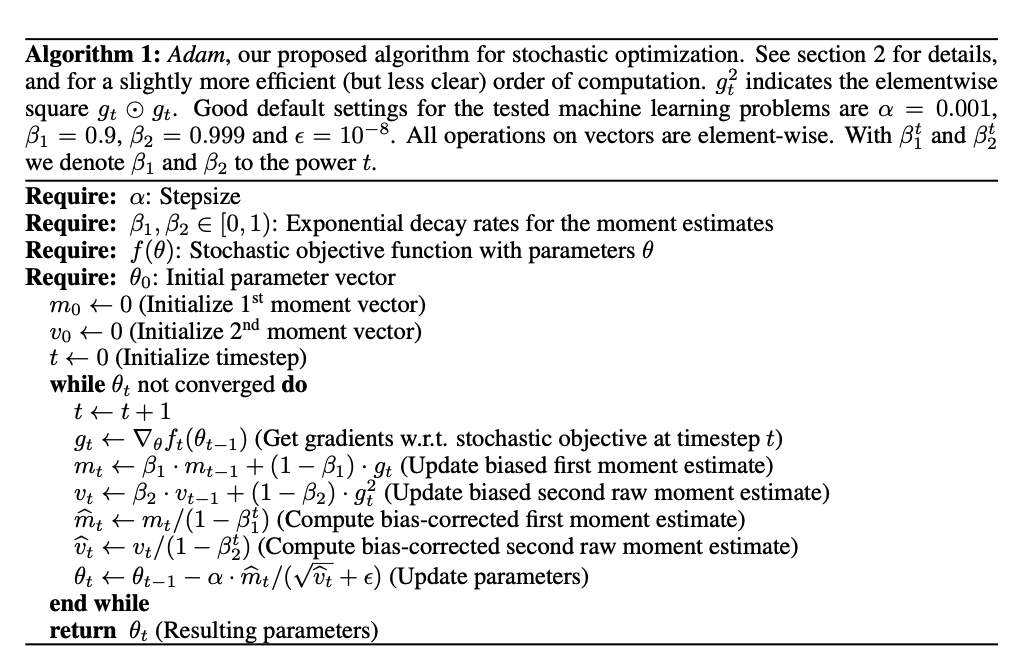

source [arxiv](https://arxiv.org/pdf/1412.6980)

In [ ]:
learning_rate = 0.1

k, b = 0, 0

m_k, m_b = 0, 0
v_k, v_b = 0, 0

beta_1 = 0.9
beta_2 = 0.999

epsilon = 1.0e-8

for i in range(1, 2001):
    dL_dk, dL_db = grad(X, y_sampled, k, b)

    m_k = beta_1 * m_k + (1 - beta_1) * dL_dk
    m_b = beta_1 * m_b + (1 - beta_1) * dL_db

    v_k = beta_1 * v_k + (1 - beta_1) * np.square(dL_dk)
    v_b = beta_1 * v_b + (1 - beta_1) * np.square(dL_db)

    m_k_ = m_k / (1 - np.power(beta_1, i))
    m_b_ = m_b / (1 - np.power(beta_1, i))

    v_k_ = v_k / (1 - np.power(beta_2, i))
    v_b_ = v_b / (1 - np.power(beta_2, i))

    k = k - learning_rate * m_k_ / (np.sqrt(v_k_) + epsilon)
    b = b - learning_rate * m_b_ / (np.sqrt(v_b_) + epsilon)

    if not i % 100:
        print(i, k, b)

    if np.isnan(k):
        break

100 2.1570395706765413 2.1570483173907173
200 5.8691569723625445 5.869337778216445
300 9.855144366832295 9.975324320699745
400 5.985638441399898 9.945789989885023
500 5.396461715357672 9.972044064619032
600 5.3990558507174855 9.974888798123454
700 5.396422287251588 9.972233611814364
800 5.398829938963563 9.974641538761217
900 5.396716127124111 9.972527662026307
1000 5.398496628845804 9.97430821865331
1100 5.39708150979824 9.972893054495836
1200 5.398105387760989 9.973916966802312
1300 5.397493178715945 9.973304735035752
1400 5.39767808091659 9.973489647593972
1500 5.3979318753143435 9.973743444629111
1600 5.3972317732402875 9.97304332640077
1700 5.398382429431078 9.974194012676119
1800 5.396779968335682 9.972591507260995
1900 5.398832819635 9.974644417311799
2000 5.396333363428553 9.972144887833272


Adam is more robust, faster method that is widely used

## Sci-kit learn

In [ ]:
reg = LinearRegression()

In [ ]:
reg.fit(X.reshape(-1, 1), y_sampled.reshape(-1, 1))

LinearRegression()

In [ ]:
y_hat = reg.predict(X.reshape(-1, 1))

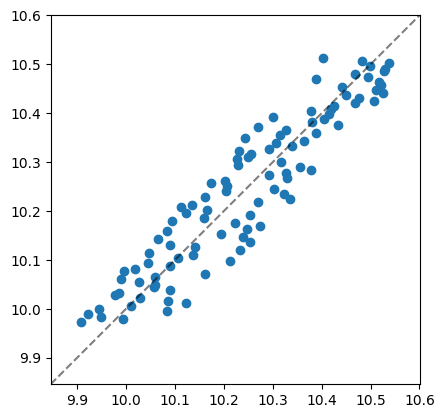

In [ ]:
fig, ax = plt.subplots(1, 1)
draw_crossplot(y_sampled, y_hat, ax)

In [ ]:
knn = KNeighborsRegressor(n_neighbors=1)

In [ ]:
knn.fit(X.reshape(-1, 1), y_sampled.reshape(-1, 1))

KNeighborsRegressor(n_neighbors=1)

In [ ]:
y_hat = knn.predict(X.reshape(-1, 1))

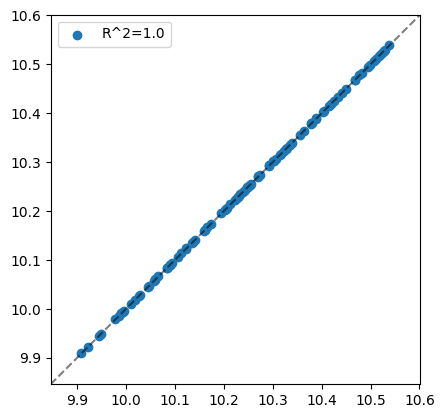

In [ ]:
fig, ax = plt.subplots(1, 1)
draw_crossplot(y_sampled, y_hat, ax, label=f'R^2={r2(y_sampled, y_hat[:, 0])}')
ax.legend()

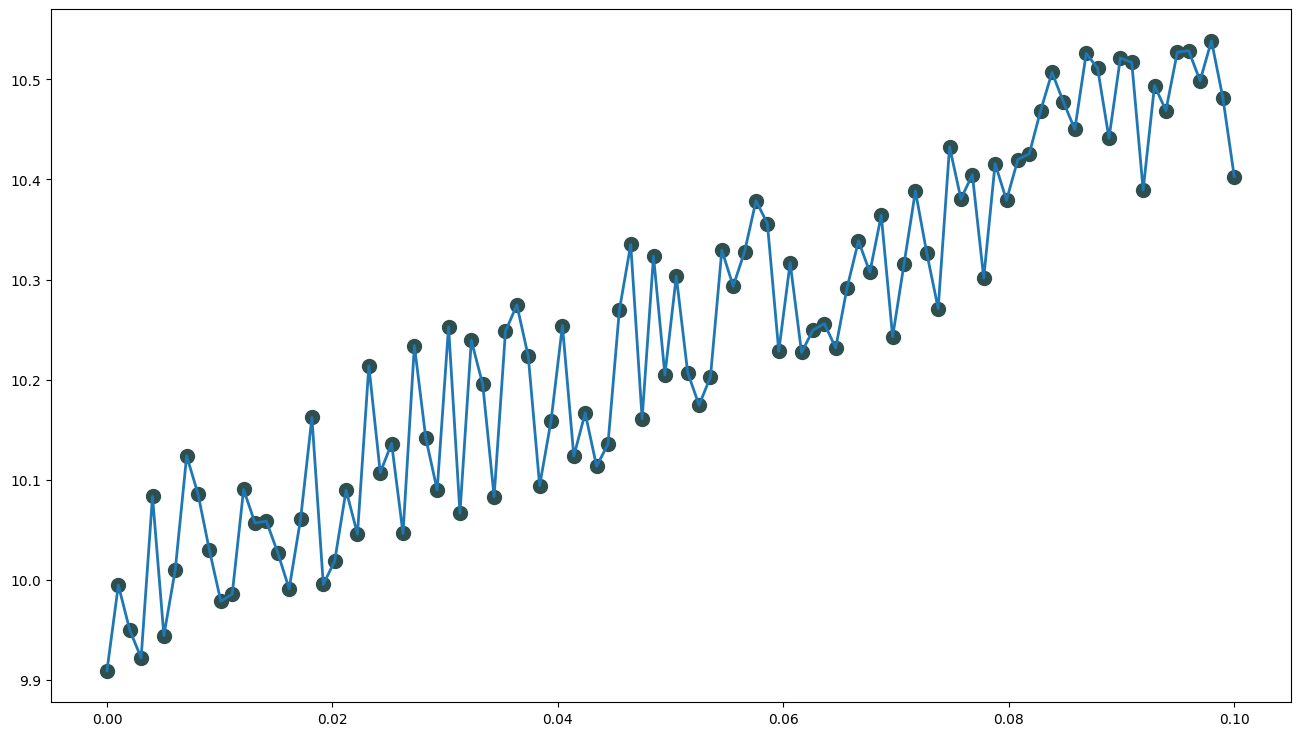

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(X, y_sampled, 'o', color='darkslategray', label='Data', markersize=10)
plt.plot(X, y_hat, '-', label=r'KNN', linewidth=2)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X.reshape(-1, 1), y_sampled.reshape(-1, 1), test_size=0.2)

In [ ]:
X_train.shape, X_val.shape

((80, 1), (20, 1))

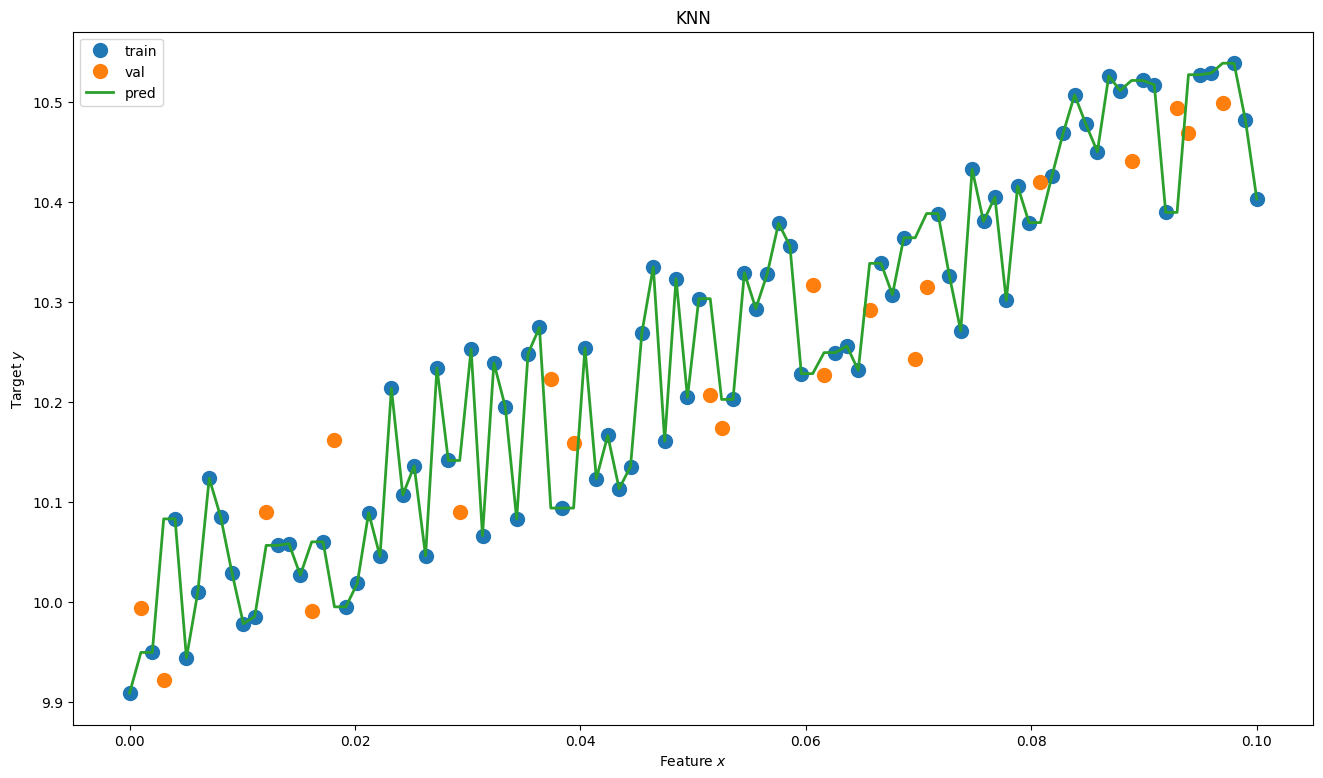

In [ ]:
knn = KNeighborsRegressor(n_neighbors=1)

knn.fit(X_train.reshape(-1, 1), y_train)
y_pred = knn.predict(X.reshape(-1, 1))
y_pred_train = knn.predict(X_train.reshape(-1, 1))
y_pred_val = knn.predict(X_val.reshape(-1, 1))

plt.figure(figsize=(16, 9))
plt.plot(X_train, y_train, 'o', label='train', markersize=10)
plt.plot(X_val, y_val, 'o', label='val', markersize=10)
plt.plot(X, y_pred, '-', label='pred', linewidth=2)
plt.xlabel('Feature $x$')
plt.ylabel('Target $y$')
plt.legend()
plt.title('KNN')
plt.show()

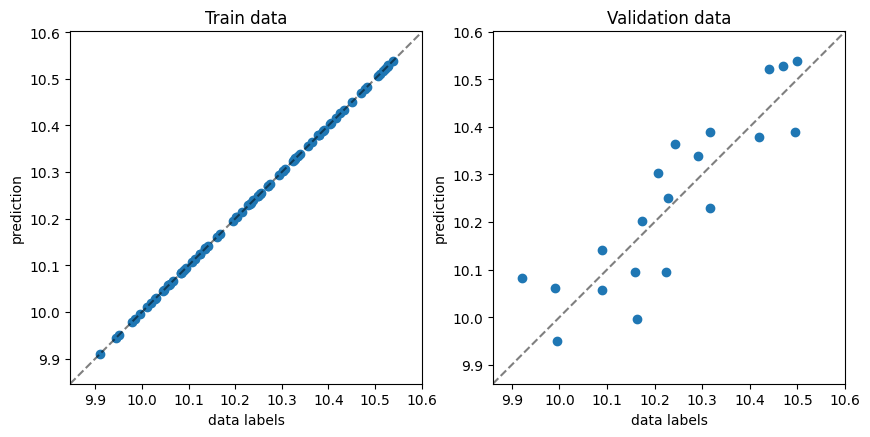

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title('Train data')
draw_crossplot(y_train, y_pred_train, ax1)
ax2.set_title('Validation data')
draw_crossplot(y_val, y_pred_val, ax2)

for ax in (ax1, ax2):
    ax.set_xlabel('data labels')
    ax.set_ylabel('prediction')